# Code Similarity with Contrastive Learning

## Dependencies

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
# Transformers (for CodeBERT)
from transformers import AutoTokenizer, AutoModel

In [3]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

NVIDIA GeForce GTX 1070
Device: cuda


## Classic Contrastive Loss Function

In [4]:
def contrastive_loss(x1, x2, label: float, margin: float):
    """
    The label indicates whether the pair is negative.
        - 1.0 means positive
        - 0.0 means negative
    
    The loss is is calculated like this:
        `dist ** 2` if the label is positive `min(margin - dist)` otherwise
    """
    with torch.device(device):
        dist = F.pairwise_distance(x1, x2)
        loss = label * torch.pow(dist, 2) + (1 - label) * torch.pow(torch.clamp(margin - dist, min=0.0), 2)
        return loss.mean()

## Model

In [5]:
# Model

class CodeSimilarityModel(nn.Module):
    def __init__(self, pretrained_model="microsoft/codebert-base", hidden_size=768):
        # NOTE: The base value for hidden_size is the size of size of the mean pooled output of the transformer.
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.transformer = AutoModel.from_pretrained(pretrained_model)
        self.transformer.to(device)
        
        # Additional projection layers for fine-tuning the embeddings
        self.proj1   = nn.Linear(hidden_size, 128)
        self.relu    = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.proj2   = nn.Linear(128, 32)
    
    def _tokenize(self, code: str):
        return self.tokenizer(code, return_tensors='pt', truncation=True, padding='max_length', max_length=256)
    
    def forward(self, code1: str, code2: str):
        # TODO: Only passing one tensor through the network MAY lead to better training time ...
        
        with torch.device(device):
            # Tokenize both code snippets
            inputs1 = self._tokenize(code1).to(device)
            inputs2 = self._tokenize(code2).to(device)
            
            # Get the transformer outputs for both inputs
            transformer_outputs1 = self.transformer(**inputs1)
            transformer_outputs2 = self.transformer(**inputs2)
            
            # Pool the transformer outputs (mean pooling)
            pooled_output1 = transformer_outputs1.last_hidden_state.mean(dim=1)
            pooled_output2 = transformer_outputs2.last_hidden_state.mean(dim=1)
            
            # Pass through the additional layers for inputs1
            x1 = self.proj1(pooled_output1)
            x1 = self.relu(x1)
            x1 = self.dropout(x1)
            x1 = self.proj2(x1)
            
            # Pass through the additional layers for inputs2
            x2 = self.proj1(pooled_output2)
            x2 = self.relu(x2)
            x2 = self.dropout(x2)
            x2 = self.proj2(x2)
            
            return x1, x2

In [6]:
# Training dataset

class CodePairDataset(Dataset):
    def __init__(self, code_pairs, labels):
        self.code_pairs = code_pairs
        self.labels     = labels

    def __getitem__(self, idx):
        code1, code2 = self.code_pairs[idx]
        label        = self.labels[idx]
        return code1, code2, torch.tensor(label, dtype=torch.float).to(device)
    
    def __len__(self):
        return len(self.code_pairs)
    
    @classmethod
    def from_csv_data(cls, path: str = "training.csv", sample_size=0):
        df = pd.read_csv(path)
        if sample_size: 
            df = df.sample(sample_size)
        code_pairs, labels = [], []
        for _, row in df.iterrows():
            x1, x2, y = row['src_x'], row['src_y'], row['label']
            code_pairs.append((x1, x2)); labels.append(y)
        return cls(code_pairs, labels)

In [7]:
# Training

def train_epoch(
    model: CodeSimilarityModel,
    margin: float,
    loader: DataLoader,
    optimizer,
    epochs: int                  = 0,  # number of epochs so far
    writer: SummaryWriter | None = None  # for logging loss values
):
    """Trains the model for one epoch."""
    N_BATCHES = len(loader)
    sum_loss = 0  # Loss accumulated per EPOCH
    cum_loss = 0  # Loss accumulated per last 25 batches
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        code1, code2, labels = data
        # Get embeddings for both code snippets
        embeddings1, embeddings2 = model(code1, code2)
        # Compute the loss
        loss = contrastive_loss(embeddings1, embeddings2, labels, margin)
        loss.backward()
        # Adjust the weights
        optimizer.step()
        # Increase loss accumulator
        cum_loss += loss.item()
        # Calculate and log loss
        if i % 25 == 24:
            last_loss = cum_loss / 25
            print('',f'Batch: {i + 1}/{N_BATCHES}, Loss: {last_loss}')
            sum_loss += cum_loss
            cum_loss = 0
            if writer is not None:  # Log the average loss over the last 25 batches
                writer.add_scalar("loss/train", last_loss, epochs * N_BATCHES + i + 1)
    # Return the average loss in the epoch
    avg_loss = sum_loss / N_BATCHES
    return avg_loss


def vdate_epoch(
    model: CodeSimilarityModel,
    margin: float,
    loader: DataLoader,
):
    """Validates the model for one epoch."""
    with torch.no_grad():
        sum_loss = 0
        for code1, code2, labels in loader:
            embeddings1, embeddings2 = model(code1, code2)
            loss = contrastive_loss(embeddings1, embeddings2, labels, margin)
            sum_loss += loss.item()
        avg_loss = sum_loss / len(loader)
        return avg_loss 


def train(
    model: CodeSimilarityModel, 
    margin: float,
    dataloaders,
    optimizer,
    epochs: int = 5,
):
    tLosses, vLosses = [], []
    writer = SummaryWriter()
    train_loader, valid_loader = dataloaders
    model.train()
    for ind_epoch in range(epochs):
        print(f'EPOCH {ind_epoch + 1}/{epochs}')
        # Train then validate
        avg_tLoss = train_epoch(model, margin, train_loader, optimizer, ind_epoch, writer)
        avg_vLoss = vdate_epoch(model, margin, valid_loader)
        # Log the losses
        print(f"EPOCH {ind_epoch + 1}/{epochs}, AVG loss: {avg_tLoss}, AVG validation loss: {avg_vLoss}")
        tLosses.append(avg_tLoss)
        vLosses.append(avg_vLoss)
    writer.close()
    return tLosses, vLosses

In [8]:
# Evaluation
# TODO

In [9]:
# Define model, tokenizer, and optimizer
model = CodeSimilarityModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

dataset = CodePairDataset.from_csv_data(sample_size=2000)
train_data, valid_data, eval_data = random_split(dataset, [1200, 500, 300])
train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=10, shuffle=True)

# NOTE: a batch size of 50 seems to crash 16 gigs of RAM (when running on CPU)

# Train the model
epochs = 5; margin = 2.5
losses = train(model, margin, (train_loader, valid_loader), optimizer, epochs)

eval_loader = DataLoader(eval_data, batch_size=10, shuffle=True)
#TODO: eval function

EPOCH 1/5
 Batch: 25/100, Loss: 2.0422044563293458
 Batch: 50/100, Loss: 1.614629225730896
 Batch: 75/100, Loss: 1.5459920930862427
 Batch: 100/100, Loss: 1.6013227415084839
EPOCH 1/5, AVG loss: 1.701037129163742, AVG validation loss: 1.633991928100586
EPOCH 2/5
 Batch: 25/100, Loss: 1.543431749343872
 Batch: 50/100, Loss: 1.6273819732666015
 Batch: 75/100, Loss: 1.585535340309143
 Batch: 100/100, Loss: 1.6050313091278077
EPOCH 2/5, AVG loss: 1.5903450930118561, AVG validation loss: 1.5805322015285492
EPOCH 3/5
 Batch: 25/100, Loss: 1.5223139476776124
 Batch: 50/100, Loss: 1.5533303546905517
 Batch: 75/100, Loss: 1.547970700263977
 Batch: 100/100, Loss: 1.6610075521469116
EPOCH 3/5, AVG loss: 1.5711556386947632, AVG validation loss: 1.597751944065094
EPOCH 4/5
 Batch: 25/100, Loss: 1.515082941055298
 Batch: 50/100, Loss: 1.542814769744873
 Batch: 75/100, Loss: 1.4693666887283325
 Batch: 100/100, Loss: 1.4614970684051514
EPOCH 4/5, AVG loss: 1.4971903669834137, AVG validation loss: 1.58

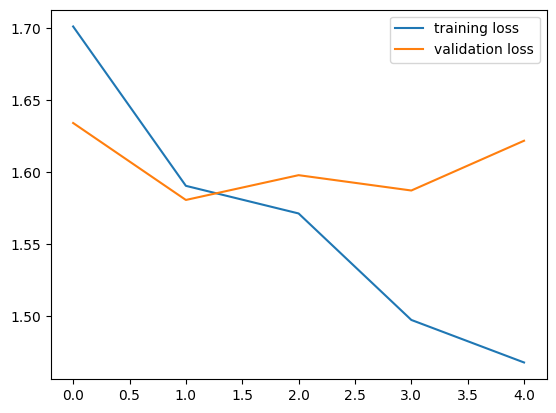

In [10]:
# TODO: FIX OVERFITTING!

plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(['training loss', 'validation loss'])
plt.show()